In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vi genererar slumpmässig datapunkter uniformt på $[0,1]^2$

In [367]:
np.random.seed(133)
N = 100 #number of data points
x = np.random.uniform(0,1, size = (2,N))

Sedan deffinerar vi en cirkel och klassifierar punkter innanför och utanför cirkeln.

Cirkeln exvation ges av $(x_1-c_1)^2 + (x_2 - c_2)^2= r^2$ så punkterna får label 1 om 
$$(x_1-c_1)^2 + (x_2 - c_2)^2 > r^2 $$

In [376]:
#n,c are the parameters fo for the hyperplane separating the two sets n*x=c
c_1 = 0.5
c_2 = 0.5
r = 0.4
y = np.zeros((N,)) #labels
for i in range(N):
    if ((x[0,i]-c_1)**2 + (x[1,i]-c_2)**2>r**2):
        y[i] = 1

In [375]:
x[:,10]

array([0.37195222, 0.80705769])

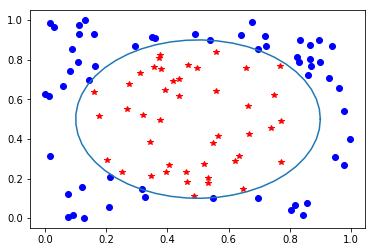

In [377]:
plt.plot(x[0,y==0],x[1,y==0],'r*') #plots all points with albels 0
plt.plot(x[0,y==1],x[1,y==1],'bo') #plots all points with labels 1 #plots the separating hyperplane
theta = np.linspace(0,2*np.math.pi)
x_c = c_1+ r*np.cos(theta)
y_c = c_2 + r*np.sin(theta)
plt.plot(x_c,y_c) #plot the circle

Punkterna ska nu klassifieras med ett neuralt nätverk med ett gömt lager. Input är två dimensionell och multipliceras med en $n_1\times 2$ dimensionell matris $W_1$, adderas med en $n_1$ dimensionell vektor $b_1$ och körs genom en icke-linjär aktiverings funktion $\sigma_1$. Det ger värdena i det gömda lagret $h_1$.
$$h_1 = \sigma_1(W_1x+b)$$
Denna output multipliceras sedan med en $1\times n_1$ dimensionell vektor $W_2$, adderas med skalären $b_2$ och körs genom en logistisk funktion $\sigma_2$
$$f = \sigma_2(W_2h_1 + b_2)$$

Nedan är ett exempel på ett lätt neuralt nätverk med tanh som aktiveringsfunktion i hidden layer. Notera att den returnerar mer än bara funktionsvärdet f. De andra värdena kan vara bra att ha när man beräknar gradienten. 

In [382]:
def f_nn(W_1,W_2, b_1,b_2,x,batch_size):
    a_1 = np.matmul(W_1,x.reshape((2,batch_size))) + b_1 #Gör beräkningen W_1x + b. Reshapar så att dimensionerna i matrismultiplikationerna blir rätt
    h_1 = np.tanh(a_1) #räknar ut värdena i hidden layer genom att ta akteveringsfunktionen på tidigare uträknat.
    a_2 = np.matmul(W_2,h_1) + b_2 #Räknar ut W_2h_1 + b_2
    f = 1/(1+np.exp(-a_2))  #räknar ut outputen, som är en sigmoid funktion.
    return (f,a_1,h_1,a_2) #Kan vara bra att returnera mer än bara funktionsvärdet för att underlätta uträckningarna i backpropagation

In [360]:
x_c = np.array([[0.2,0.3],[0.4,0.5],[0.6,0.7]])
f,a_1,h_1,a_2 = f_nn(W_1,W_2,b_1,b_2,x_c,3)

[[0.2 0.3 0.4]
 [0.5 0.6 0.7]]


In [392]:
def loss(y,f):
    return np.mean(-y*np.log(f+1e-15) - (1-y)*np.log(1-f+1e-15))

def loss_der(y,f):
    return (-y*1/(f+1e-15) + (1-y)*1/(1-f+1e-15))

def tanh_der(x):
    return 1-np.tanh(x)**2

def accuracy(W_1,W_2,b_1,b_2):
    NN = 10000
    x_test = np.random.uniform(0,1,size=(2,NN))
    y_test = (x_test[0,:]-c_1)**2 + (x_test[1,:]-c_2)**2>r**2
    f,_,_,_ =  f_nn(W_1,W_2,b_1,b_2,x_test,NN)
    f_test = f>1/2
    return np.mean(y_test==f_test)

Vi initierar vikterna slumpvis, tar bredden 4 i hidden layer.

In [395]:
n_1 = 100
W_1 = np.random.normal(size= (n_1,2))
W_2 = np.random.normal(size = (1,n_1))
b_1 = np.random.normal(size= (n_1,1))
b_2 = np.random.normal(size = (1,1))

In [396]:
batch_size = 1
epochs = 10
step_size = 0.1
for i in range(100):
    for j in range(100):
        ind = np.random.choice(N)
        x_ind = x[:,ind]
        y_ind = y[ind]
        f,a_1,h_1,a_2 = f_nn(W_1,W_2,b_1,b_2,x_ind,batch_size)
        loss_step = loss(y_ind,f)
        delta_2 = loss_der(y_ind,f)*1/(1+np.exp(-a_2))*(1-1/(1+np.exp(-a_2)))
        dL_dW_2 = h_1.transpose()*delta_2
        dL_db_2 = delta_2
        delta_1 = (W_2.transpose()*delta_2)*tanh_der(a_1)
        dL_dW_1 = np.outer(delta_1,x_ind)
        dL_db_1 = delta_1
        W_1 = W_1 - step_size*dL_dW_1
        W_2 = W_2 - step_size*dL_dW_2
        b_1 = b_1 - step_size*dL_db_1
        b_2 = b_2 - step_size*dL_db_2
    f,_,_,_ = f_nn(W_1,W_2,b_1,b_2,x,100)
    print("Loss: {}        accuracy= {}".format(loss(y,f),accuracy(W_1,W_2,b_1,b_2)))

Loss: 1.1751009844872047        accuracy= 0.4337
Loss: 0.5317465288477706        accuracy= 0.6117
Loss: 0.7308100916986335        accuracy= 0.6341
Loss: 0.3520775656982029        accuracy= 0.8648
Loss: 0.425568482589397        accuracy= 0.7767
Loss: 0.2941465037964852        accuracy= 0.9031
Loss: 0.5258547257299532        accuracy= 0.7609
Loss: 0.21826147920705857        accuracy= 0.9118
Loss: 0.21123023227755894        accuracy= 0.8869
Loss: 0.5586919418436572        accuracy= 0.7448
Loss: 0.5900563477309423        accuracy= 0.6871
Loss: 0.6315049464671477        accuracy= 0.6682
Loss: 0.22146602637147617        accuracy= 0.8769
Loss: 0.3629812703396532        accuracy= 0.7901
Loss: 0.3145140662824385        accuracy= 0.8308
Loss: 0.7049642404747106        accuracy= 0.6486
Loss: 0.2600167937304551        accuracy= 0.8242
Loss: 0.1989104028392023        accuracy= 0.8736
Loss: 0.18259408556544102        accuracy= 0.8748
Loss: 0.22140222674507967        accuracy= 0.8689
Loss: 0.22241544

In [387]:
x_test = np.random.uniform(0,1,size=(2,100))
y_test = (x_test[0,:]-c_1)**2 + (x_test[1,:]-c_2)**2>r**2
f,_,_,_ =  f_nn(W_1,W_2,b_1,b_2,x_test,100)
f_test = f>1/2
f_test


array([[ True,  True, False,  True, False,  True, False, False, False,
         True,  True, False, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False, False,  True,  True, False,
        False,  True, False,  True, False,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,
        False, False, False,  True,  True, False,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
        False]])

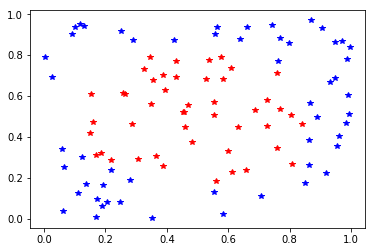

In [388]:
NN = 100
x_test = np.random.uniform(0,1,size=(2,NN))
y_test = (x_test[0,:]-c_1)**2 + (x_test[1,:]-c_2)**2>r**2
f,_,_,_ =  f_nn(W_1,W_2,b_1,b_2,x_test,NN)
f = f.reshape((NN,))
f_test = f>1/2
plt.plot(x_test[0,f_test == 0],x_test[1,f_test==0],'r*')
plt.plot(x_test[0,f_test == 1],x_test[1,f_test==1],'b*')

(1, 10000)

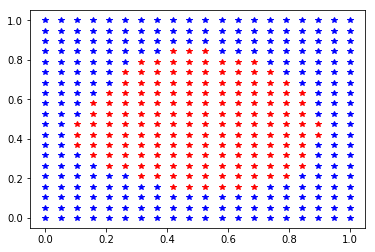

In [397]:
x_1 = np.linspace(0,1,20)
x_2 = np.linspace(0,1,20)
for i in x_1:
    for j in x_2:
        f,_,_,_ = f_nn(W_1,W_2,b_1,b_2,np.array([i,j]),1)
        if f>1/2:
            plt.plot(i,j,'b*')
        else:
            plt.plot(i,j,'r*')

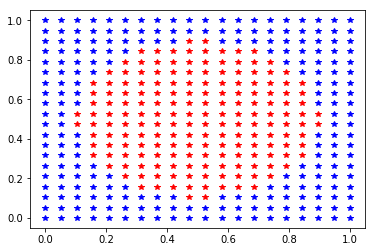

In [255]:
x_1 = np.linspace(0,1,20)
x_2 = np.linspace(0,1,20)
for i in x_1:
    for j in x_2:
        if (i-c_1)**2 + (j-c_2)**2>r**2:
            plt.plot(i,j,'b*')
        else:
            plt.plot(i,j,'r*')

In [247]:
f,a_1,h_1,a_2 = f_nn(W_1,W_2,b_1,b_2,x[:,:],100)
f

array([[2.12554644e-11, 9.99995413e-01, 9.99998360e-01, 7.35327870e-01,
        2.99703757e-11, 7.11761008e-08, 4.14453882e-05, 3.23513850e-10,
        2.09319250e-04, 9.99999528e-01, 4.02638420e-08, 9.99999833e-01,
        9.55627032e-01, 4.32725133e-06, 2.96190522e-01, 9.99068716e-01,
        6.99870780e-01, 7.89273046e-12, 1.86896935e-09, 3.05069825e-06,
        1.01948657e-09, 7.04446913e-07, 7.16999318e-12, 6.67834734e-03,
        6.36770151e-10, 9.14646077e-01, 9.83881724e-01, 9.99962125e-01,
        4.63933295e-10, 9.99995315e-01, 3.14756609e-10, 9.99374735e-01,
        9.98132877e-01, 2.49975298e-05, 9.99679008e-01, 4.32396178e-08,
        8.34479188e-06, 7.39974794e-01, 9.99911405e-01, 7.74210447e-11,
        2.87858041e-01, 9.99999806e-01, 9.97975439e-01, 9.97439602e-01,
        2.74655195e-07, 9.49209613e-01, 3.01171399e-03, 9.99845815e-01,
        1.81885411e-09, 7.73413088e-11, 2.48047519e-10, 7.06181558e-09,
        2.18053011e-08, 9.99768061e-01, 3.14480581e-08, 9.999473

In [251]:
dL_db_2

array([[-0.09968595]])

In [257]:
ct = np.random.uniform(0,1,size = (100,2))
ct[:,0] + ct[:,1]>1

array([ True, False, False,  True,  True, False,  True, False, False,
        True, False,  True, False, False, False,  True, False,  True,
        True, False, False, False, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True, False,  True, False,  True, False,  True, False, False,
        True, False, False, False,  True,  True, False, False,  True,
       False,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
        True])

In [260]:
False*False

0

Nu är det bara att träna vikterna i NN med gradient descent. Klarar den inte av att klassifiera punkterna så testa att göra bredden i det gömda lagret större